In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from datetime import datetime

In [2]:
# read in the data
df = pd.read_csv('CalIt2.data.csv')
# restrict data to only inflow (flow == 9)
df = df[df["flow"] == 9].reset_index(drop = True)
df = df.drop("flow", axis = 1)
# clean up datetime values
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time_stamp'])
# each 30 minute window of the day is given a number from 0 to 47
df['step'] = df['datetime'].apply(lambda x: x.hour * 2 + x.minute // 30)
# each day of the week is given a number from 0 to 6 (0 is monday)
df['day'] = df['datetime'].dt.weekday
# drop date and time_stamp columns for ease of reading
df.drop(["date", "time_stamp"], axis = 1, inplace = True)


In [3]:
# read in confirmation data
events_df = pd.read_csv('CalIt2.events.csv')
# clean up datetime
events_df['start'] = pd.to_datetime(events_df['date'] + ' ' + events_df['time_start'])
events_df['end'] = pd.to_datetime(events_df['date'] + ' ' + events_df['time_end'])
events_df.drop(["date", "time_start", "time_end"], axis = 1, inplace = True)

In [4]:
df.describe()

,count,step,day
count,5040.000000,5040.000000,5040.000000
mean,3.888294,23.500000,3.000000
std,6.834565,13.854774,2.000198
min,0.000000,0.000000,0.000000
25%,0.000000,11.750000,1.000000
50%,0.000000,23.500000,3.000000
75%,5.250000,35.250000,5.000000
max,62.000000,47.000000,6.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5040 entries, 0 to 5039
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   count     5040 non-null   int64         
 1   datetime  5040 non-null   datetime64[ns]
 2   step      5040 non-null   int64         
 3   day       5040 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 157.6 KB


In [6]:
df.head()

,count,datetime,step,day
0,0,2005-07-24 00:00:00,0,6
1,0,2005-07-24 00:30:00,1,6
2,0,2005-07-24 01:00:00,2,6
3,0,2005-07-24 01:30:00,3,6
4,0,2005-07-24 02:00:00,4,6


In [7]:
events_df.head()

,occurence,start,end
0,10; event,2005-07-26 11:00:00,2005-07-26 14:00:00
1,10; event,2005-07-29 08:00:00,2005-07-29 11:00:00
2,10; event,2005-08-02 15:30:00,2005-08-02 16:30:00
3,30; event,2005-08-04 16:30:00,2005-08-04 17:30:00
4,10; event,2005-08-05 08:00:00,2005-08-05 11:00:00


In [8]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   occurence  30 non-null     object        
 1   start      30 non-null     datetime64[ns]
 2   end        30 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 848.0+ bytes


In [9]:
events_df.describe()

/var/folders/78/bnqlwlkd7t1fgn2y34x1tkfh0000gn/T/ipykernel_97269/940118046.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  events_df.describe()
/var/folders/78/bnqlwlkd7t1fgn2y34x1tkfh0000gn/T/ipykernel_97269/940118046.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  events_df.describe()


,occurence,start,end
count,30,30,30
unique,5,30,30
top,10; event,2005-07-26 11:00:00,2005-07-26 14:00:00
freq,14,1,1
first,NaN,2005-07-26 11:00:00,2005-07-26 14:00:00
last,NaN,2005-10-24 16:00:00,2005-10-24 21:00:00


In [65]:
class MMPP(object):
    def __init__(self, df):
        self.counter = 0 # counter variable
        self.df = df
        self.D = 48 # break-up of time periods
        self.L = df.shape[0] # number of rows
        # initialize hyperparameters
        self.S = np.zeros((7, self.D))
        self.ZZ = np.zeros((3, 3))
        self.aL, self.bL = 1, 1 # lambda_0
        self.aE, self.bE = 5, 1/3 # gamma
        self.alpha_d = np.ones(7) * 5 # delta_i
        self.alpha_h = np.ones((7, 48)) # eta
        self.az = np.asarray([np.asarray([.98, .01, .01]) * 10000, 
                              np.asarray([.24, .75, .01]) * 10000, 
                              np.asarray([.24, .01, .75]) * 10000]) # transition
        # initialize parameters
        self.lam0 = 0
        self.gam0 = 0
        self.deltas = np.zeros((7, 1))
        self.etas = np.zeros((7, 48))
        self.Mz = np.zeros((3, 3))
        # initialize data
        self.N_vals = self.df["count"]
        self.delta_vals = self.df["day"].apply(lambda x: self.deltas[x])
        self.eta_vals = self.df.apply(lambda row: self.etas[row["day"]][row["step"]], axis = 1)
        self.lambdas = self.lam0 * np.multiply(self.delta_vals, self.eta_vals)
        self.states = np.zeros((3, 1))
        # initialize predictions
        self.N0 = []
        self.NE = []
        self.Z = []
        self.pZneq0 = []
    
    def generate_params(self):
        lam0 = stats.gamma.rvs(self.aL + np.sum(self.S), scale = 1/(self.bL + self.L))
        gam0 = stats.gamma.rvs(self.aE, scale = 1/self.bE)
        deltas = 7 * np.random.dirichlet(self.alpha_d + np.sum(self.S, axis = 1))
        etas = 48 * np.apply_along_axis(np.random.dirichlet, 1, self.alpha_h + self.S)
        Mz = np.apply_along_axis(np.random.dirichlet, 1, self.az + self.ZZ)
        self.lam0 = lam0 
        self.gam0 = gam0
        self.deltas = deltas 
        self.etas = etas 
        self.Mz = Mz
        self.delta_vals = self.df["day"].apply(lambda x: self.deltas[x])
        self.eta_vals = self.df.apply(lambda row: self.etas[row["day"]][row["step"]], axis = 1)
        self.lambdas = self.lam0 * np.multiply(self.delta_vals, self.eta_vals)
        
    def prob_N_given_z(self, lam, N):
        p = stats.poisson(lam)
        n = stats.nbinom(self.aE, self.bE / (1 + self.bE))
        z0 = p.pmf(N)
        zpos = sum([p.pmf(N - i) * n.pmf(i) for i in range(N + 1)])
        zneg, j = 0, 0
        while p.pmf(N + j) > 1e-4:
            zneg += p.pmf(N + j) * n.pmf(j)
            j += 1
        
        return np.asarray([z0, zpos, zneg]) / sum([z0, zpos, zneg])
    
    def mat_pNz(self):
        # initialize matrix
        M = []
        for i in range(self.L):
            M.append(self.prob_N_given_z(self.lambdas[i], self.N_vals[i]))
        return np.asarray(M)
    
    def steady_state(self):
        # find steady state values given transition matrix Mz
        # take eigenvalues of the transposed matrix
        eig_val, eig_vec = np.linalg.eig(self.Mz.T)
        # find index of the eigenvalue that is close to one
        index = np.isclose(eig_val, 1)
        # use index to identify row vector associated with one
        state = eig_vec[:, index][:, 0]
        # turn elements into probabilities
        state /= sum(state)
        return np.abs(state)

    def sample_next_Z(self, z, P):
        weights = np.zeros(3)
        for i in range(3):
            weights[i] = self.Mz[i][z] * self.states[i] ** 2 * P[i] / self.states[z]
        weights /= sum(weights)
        self.pZneq0.append(weights[1] + weights[2])
        return np.random.choice([0, 1, 2], p = weights)
    
    def draw_Z(self):
        # find p(N(t)|z(t)) for each N, lambda pair
        M = self.mat_pNz()
        # empty Z and pZneq0
        self.Z = []
        self.pZneq0 = []
        # sample the first element and add to Z
        weights = M[-1] / sum(M[-1])
        self.Z.append(np.random.choice([0, 1, 2], p = weights))
        self.pZneq0.append(weights[1] + weights[2])

        # draw the next element with conditional probability of next Z
        for i in range(1, self.L):
                self.Z.append(self.sample_next_Z(self.Z[i - 1], M[self.L - i]))
        
        self.Z = self.Z[::-1]
        self.pZneq0 = self.pZneq0[::-1]

    def draw_N(self):
        n = stats.nbinom(self.aE, self.bE / (1 + self.bE))    
        # empty N0 and NE
        self.N0 = []
        self.NE = []
        for i in range(self.L):
            p = stats.poisson(self.lambdas[i])
            if self.Z[i] == 0:
                self.N0.append(self.N_vals[i])
                self.NE.append(0)
            elif self.Z[i] == 1:
                weights = [p.pmf(self.N_vals[i] - k) * n.pmf(k) for k in range(self.N_vals[i] + 1)]
                weights = np.asarray(weights)
                weights /= sum(weights)
                val = np.random.choice([k for k in range(len(weights))], p = weights)
                self.N0.append(self.N_vals[i] - val)
                self.NE.append(val)
            else:
                j = 0
                weights = []
                while p.pmf(self.N_vals[i] + j) > 1e-4:
                    weights.append(p.pmf(self.N_vals[i] + j) * n.pmf(j))
                    j += 1
                weights = np.asarray(weights)
                # case where tail is too large
                if len(weights) == 0:
                    self.N0.append(self.N_vals[i])
                    self.NE.append(0)
                else:
                    weights /= sum(weights)
                    val = np.random.choice([k for k in range(len(weights))], p = weights)
                    self.N0.append(self.N_vals[i] + val)
                    self.NE.append(val)

    # backward pass update of poisson hyperparameters
    def find_S(self):
        self.S = np.zeros((7, self.D))
        for i in range(self.L):
            self.S[self.df["day"][i]][self.df["step"][i]] += self.N0[i]
    
    # backward pass update of transition matrix hyperparameters
    def find_ZZ(self):
        self.ZZ = np.zeros((3, 3))
        for i in range(1, self.L):
            self.ZZ[self.Z[i - 1]][self.Z[i]] += 1
    
    def run_model(self, iters):
        for i in range(iters):
            print(f"running iteration {i + 1} of {iters}  |  total iterations: {self.counter + 1}")
            self.run_forward_backward()
            self.counter += 1
    
    def update_event_hypers(self):
        self.aE = sum(self.NE)
        self.bE = sum(self.Z)

    def run_forward_backward(self):
        # generate new parameters
        self.generate_params()
        self.states = self.steady_state()
        # perform forward pass
        self.draw_Z()
        self.draw_N()
        # perform backward pass
        self.update_event_hypers()
        self.find_S()
        self.find_ZZ()           

In [66]:
mmpp = MMPP(df)

In [67]:
mmpp.run_model(50)

running iteration 1 of 50  |  total iterations: 1
running iteration 2 of 50  |  total iterations: 2
running iteration 3 of 50  |  total iterations: 3
running iteration 4 of 50  |  total iterations: 4
running iteration 5 of 50  |  total iterations: 5
running iteration 6 of 50  |  total iterations: 6
running iteration 7 of 50  |  total iterations: 7
running iteration 8 of 50  |  total iterations: 8
running iteration 9 of 50  |  total iterations: 9
running iteration 10 of 50  |  total iterations: 10
running iteration 11 of 50  |  total iterations: 11
running iteration 12 of 50  |  total iterations: 12
running iteration 13 of 50  |  total iterations: 13
running iteration 14 of 50  |  total iterations: 14
running iteration 15 of 50  |  total iterations: 15
running iteration 16 of 50  |  total iterations: 16
running iteration 17 of 50  |  total iterations: 17
running iteration 18 of 50  |  total iterations: 18
running iteration 19 of 50  |  total iterations: 19
running iteration 20 of 50  | 

In [68]:
# add values back into df
df["N0"] = mmpp.N0
df["lambdas"] = mmpp.lambdas
df["Z"] = mmpp.Z
df["NE"] = mmpp.NE
df["p(z != 0)"] = mmpp.pZneq0

In [69]:
df.describe()

,count,step,day,N0,lambdas,Z,NE,p(z != 0)
count,5040.000000,5040.000000,5040.000000,5040.000000,5040.000000,5040.000000,5040.000000,5.040000e+03
mean,3.888294,23.500000,3.000000,3.727579,3.738303,0.014881,0.165873,1.436706e-02
std,6.834565,13.854774,2.000198,6.483082,5.524601,0.122716,1.894694,1.093914e-01
min,0.000000,0.000000,0.000000,0.000000,0.000801,0.000000,0.000000,4.607852e-09
25%,0.000000,11.750000,1.000000,0.000000,0.119243,0.000000,0.000000,1.020647e-08
50%,0.000000,23.500000,3.000000,0.000000,0.599917,0.000000,0.000000,1.297090e-07
75%,5.250000,35.250000,5.000000,5.000000,6.478324,0.000000,0.000000,2.351493e-05
max,62.000000,47.000000,6.000000,61.000000,21.263518,2.000000,49.000000,1.000000e+00


In [70]:
df[100:120]

,count,datetime,step,day,N0,lambdas,Z,NE,p(z != 0)
100,0,2005-07-26 02:00:00,4,1,0,0.080465,0,0,8.458751e-09
101,0,2005-07-26 02:30:00,5,1,0,0.079279,0,0,7.399216e-09
102,0,2005-07-26 03:00:00,6,1,0,0.041408,0,0,8.889583e-09
103,0,2005-07-26 03:30:00,7,1,0,0.091349,0,0,1.215257e-08
104,0,2005-07-26 04:00:00,8,1,0,0.171962,0,0,8.288813e-09
105,0,2005-07-26 04:30:00,9,1,0,0.073593,0,0,8.012029e-08
106,0,2005-07-26 05:00:00,10,1,0,0.657074,0,0,5.326497e-07
107,2,2005-07-26 05:30:00,11,1,2,1.236114,0,0,6.273753e-06
108,3,2005-07-26 06:00:00,12,1,3,1.132243,0,0,1.444887e-06
109,2,2005-07-26 06:30:00,13,1,2,0.685497,0,0,2.128445e-04


In [71]:
mmpp.prob_N_given_z(14.443170, 26)

array([2.36199359e-02, 9.76345283e-01, 3.47813889e-05])

In [72]:
# recreate figure 9 data
fig9_data = df[(df["datetime"] >= '9/25/2005') & (df["datetime"] <= '10/15/2005')]
fig9_events = events_df[(events_df["start"] >= '9/25/2005') & (events_df["start"] <= '10/15/2005')]

[]

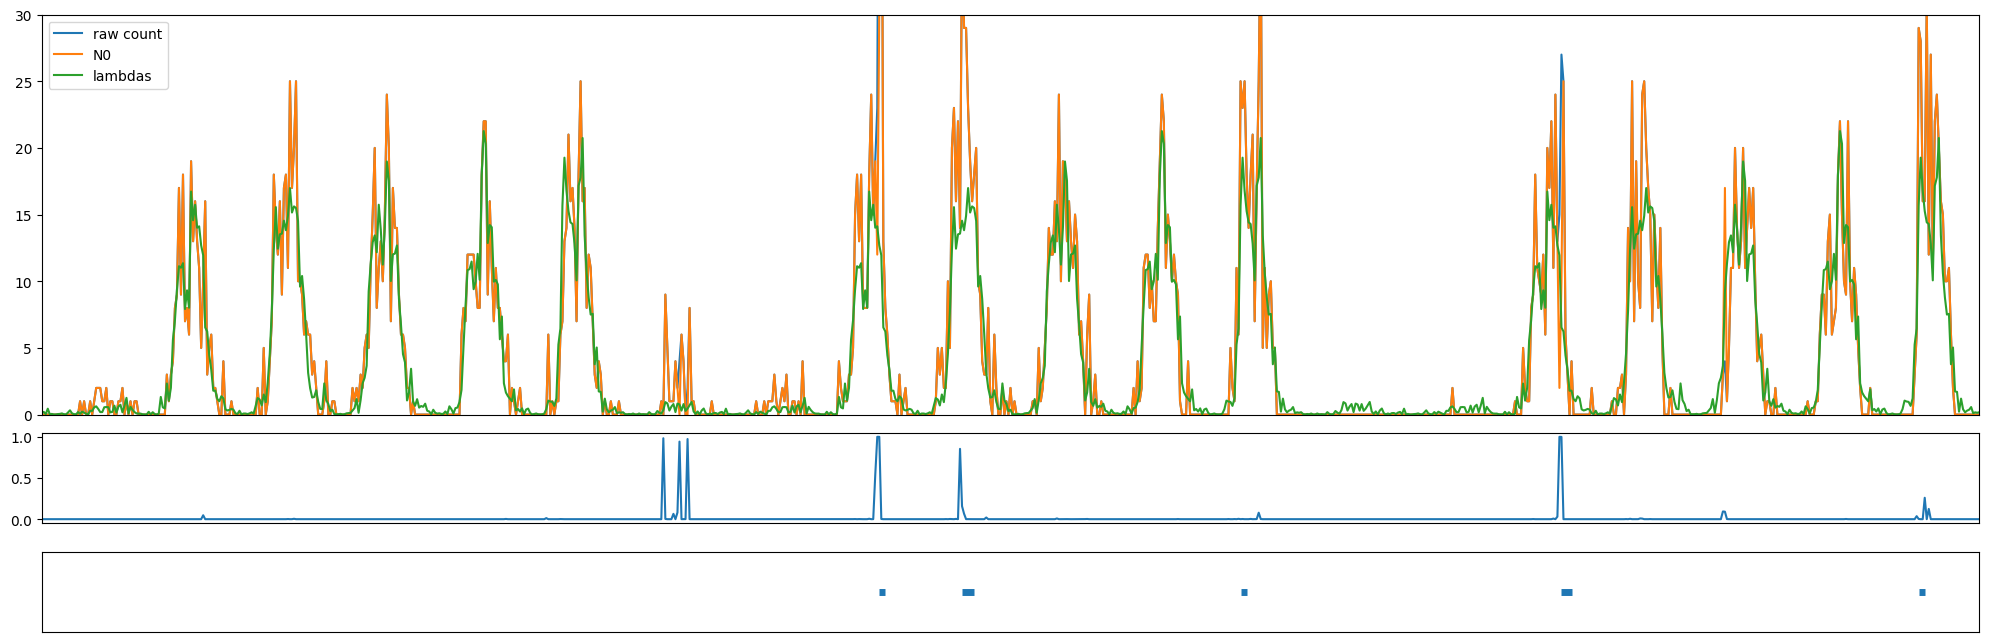

In [73]:
# plot figure 9
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (25, 4), sharex = True)

# plot figure 9(a)
ax1_pos = ax1.get_position()
ax1.set_position([ax1_pos.x0, ax1_pos.y0, ax1_pos.width, 1])
ax1.set_xlim(left = min(fig9_data.index), right = max(fig9_data.index))
ax1.set_ylim(0, 30)
ax1.plot(fig9_data.index, fig9_data["count"], label = "raw count")
ax1.plot(fig9_data.index, fig9_data["N0"], label = "N0")
ax1.plot(fig9_data.index, fig9_data["lambdas"], label = "lambdas")
ax1.legend()

# plot figure 9(b)
ax2_pos = ax2.get_position()
ax2.plot(fig9_data.index, fig9_data["p(z != 0)"])

# plot figure 9(c)
for index, row in fig9_events.iterrows():
    start = int(fig9_data[fig9_data["datetime"] == row["start"]].index[0])
    end = int(fig9_data[fig9_data["datetime"] == row["end"]].index[0])
    ax3.hlines(y = 0.5, xmin = start, xmax = end, lw = 5)
ax3.set_xlim(left = min(fig9_data.index), right = max(fig9_data.index))
ax3_pos = ax3.get_position()
ax3.set_position([ax3_pos.x0, ax3_pos.y0, ax3_pos.width, .2])
ax3.set_xticks([])
ax3.set_yticks([])

plt.plot()